# Анализ случайного леса
### AI Community: Практический курс по машинному обучению
#### Материалы подготовлены EORA Data Lab

Случайный лес прост в использовании и настройке, при этом не склонен к переобучению. Рассмотрим подробнее его настройку.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rfpimp

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier

sns.set()
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Настройка параметров
Сгенерируем два класса точек на плоскости.

In [6]:
n_points = 2000
x = np.vstack([np.random.normal(loc=0.8, size=(n_points, 2)),
               np.random.normal(loc=-0.8, size=(n_points, 2))])
y = np.array([0] * n_points + [1] * n_points)

In [7]:
def plot_predictions(X, y, clf, proba=False, points_size=7):
    """Fits the classifier on the data (X, y) and plots the result on a 2-D plane."""
    def get_grid(data):
        x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
        y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
        return np.meshgrid(np.arange(x_min, x_max, 0.01),
                           np.arange(y_min, y_max, 0.01))
    
    clf.fit(X, y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    plt.figure(figsize=(10.0, 10.0))
    plt.pcolormesh(xx, yy, predicted, cmap=plt.cm.RdBu, alpha=0.1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=points_size, cmap=plt.cm.RdBu, alpha=0.90)
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    plt.xlabel('x')
    plt.ylabel('y')
    
    return clf

Обучим случайный лес со стандартными параметрами.

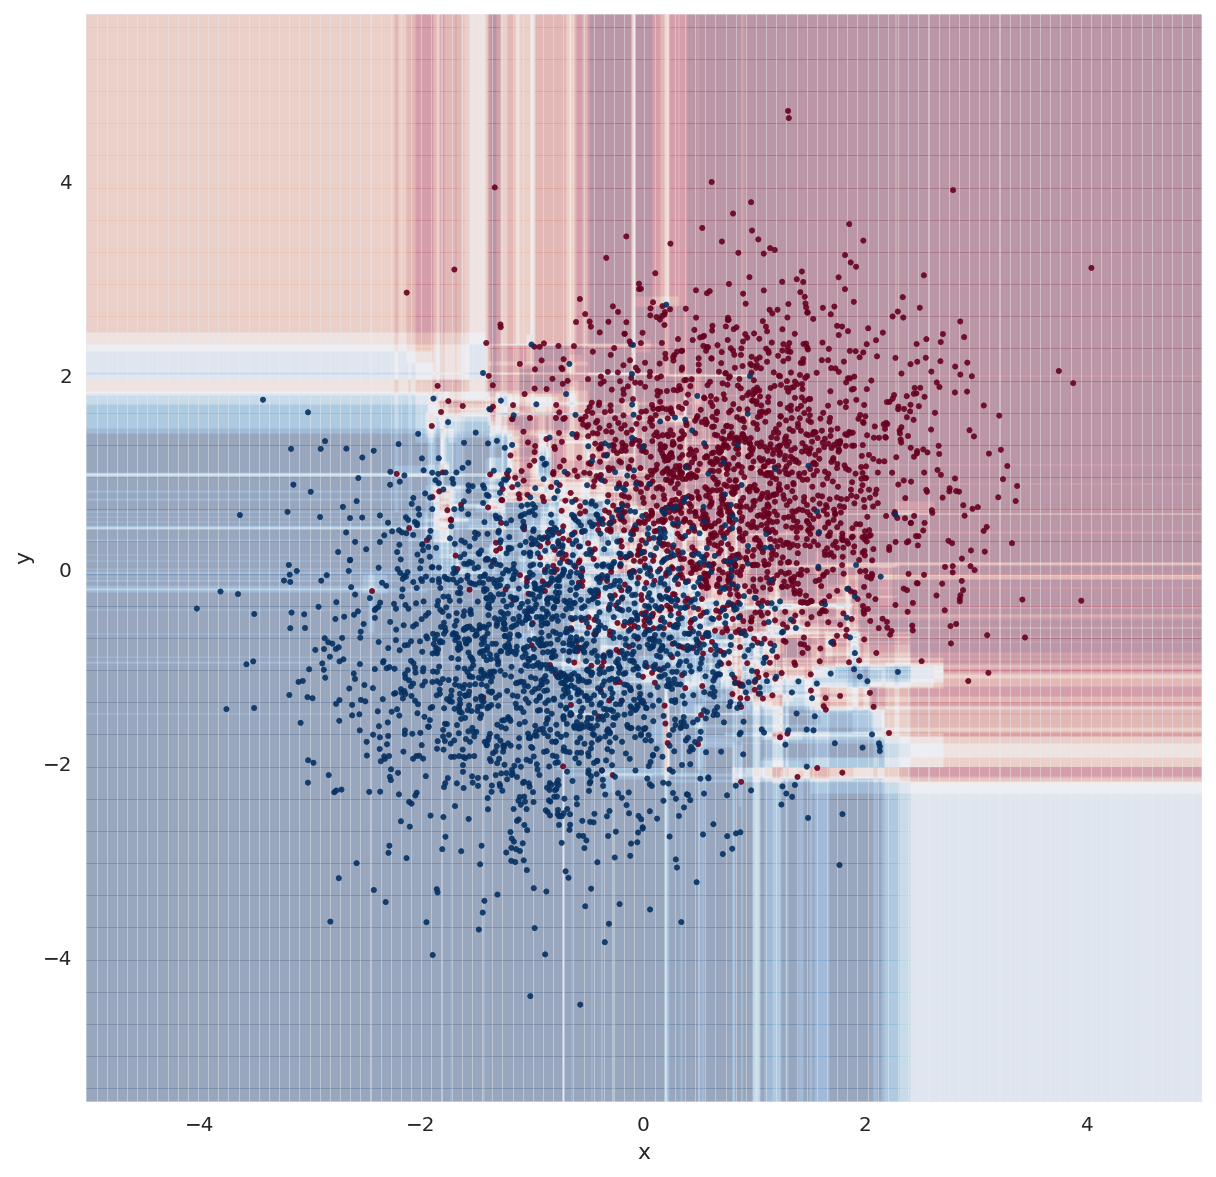

In [8]:
clf = RandomForestClassifier()
plot_predictions(x, y, clf, proba=True);

Можно заметить что есть некоторый эффект переобучения: полоски вокруг объектов-выбросов.  
На влияние выбросов можно повлиять изменяя следующие параметры:
* максимальная глубину дерева: `max_depth`
* максимальное число листьев: `max_leaf_nodes`
* минимальное число объектов в листе дерева: `min_samples_leaf`
* минимальное число объектов во внутренней вершине дерева, при котором ее нужно разделить: `min_samples_split`  

Все эти параметры накладывают ограничения на структуру дерева, а значит они отвечают за настройку одного и того же, но немного по разному. Поэтому комбинировать их излишне и скорее всего не принесет заметной пользы.  
По сути все эти параметры обменивают bias на variance.

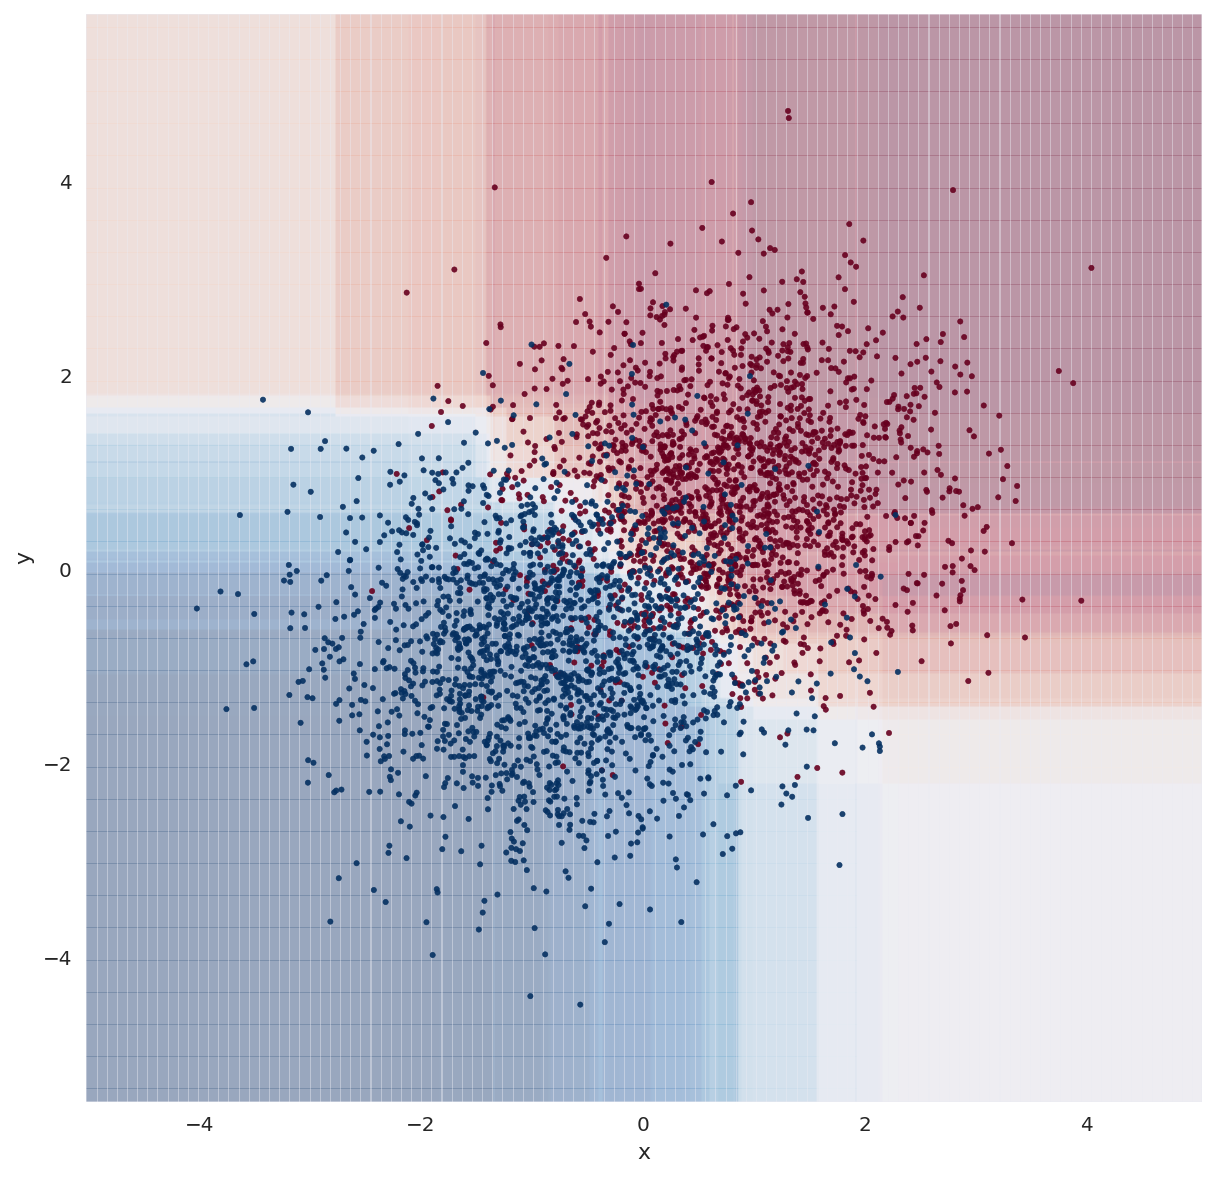

In [5]:
clf = RandomForestClassifier(max_depth=4)
plot_predictions(x, y, clf, proba=True);

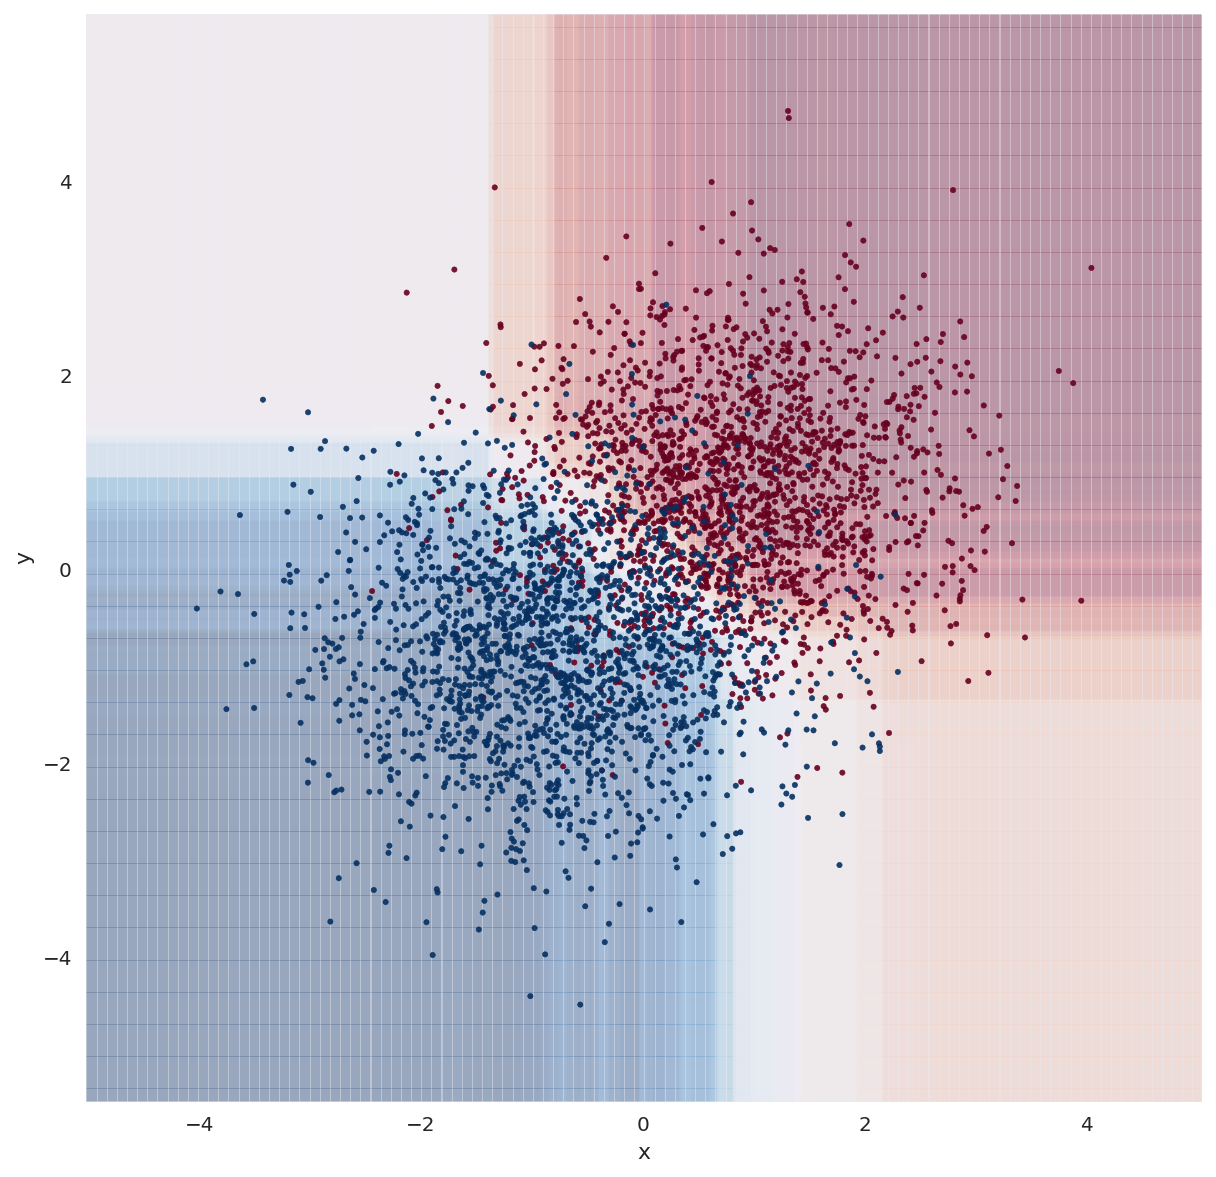

In [9]:
clf = RandomForestClassifier(min_samples_leaf=50)
plot_predictions(x, y, clf, proba=True);

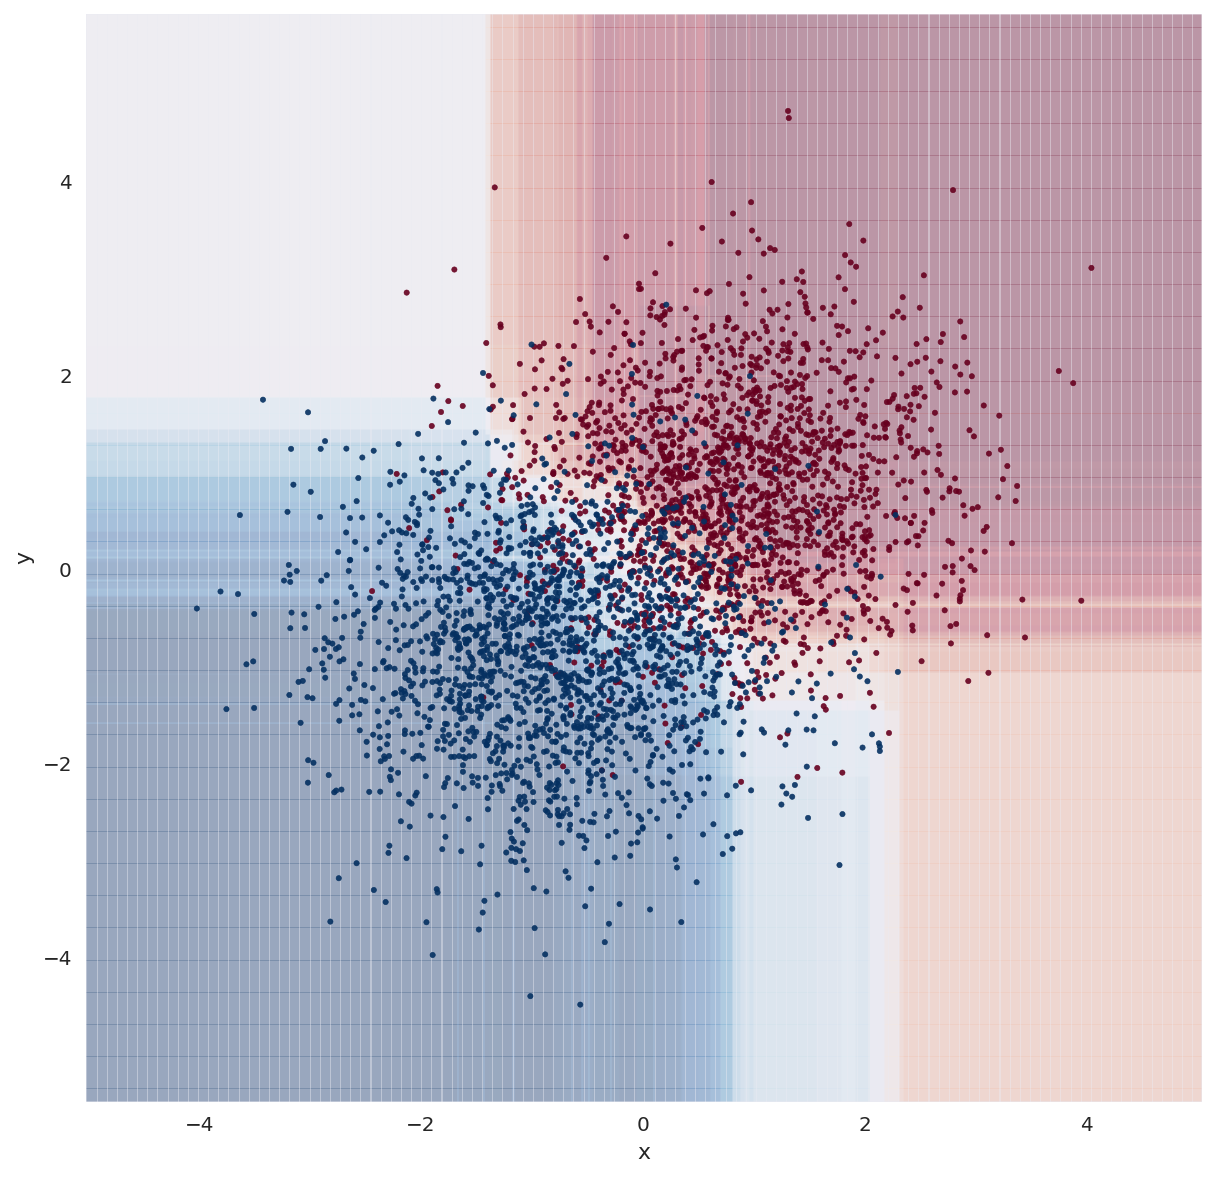

In [11]:
clf = RandomForestClassifier(min_samples_split=100)
plot_predictions(x, y, clf, proba=True);

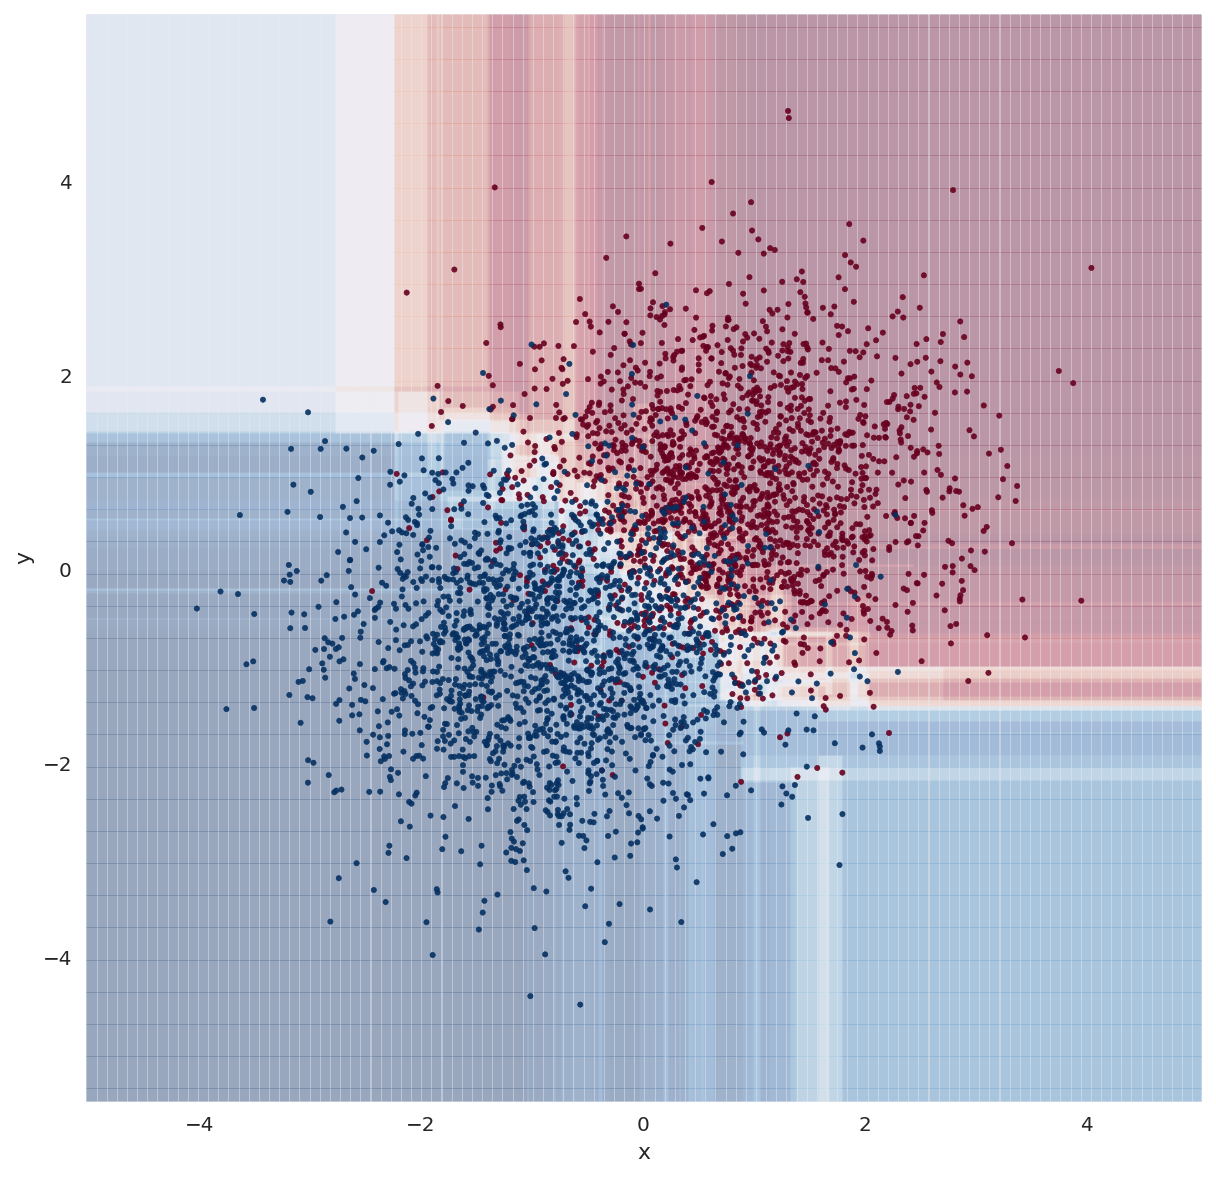

In [12]:
clf = RandomForestClassifier(max_leaf_nodes=60)
plot_predictions(x, y, clf, proba=True);

После настройки архитектуры дерева следует повышать количество деревьев в ансамбле.  
Прирост качества после добавления каждого следующего дерева становится все меньше, поэтому следует добавлять деревья пока это разумно.

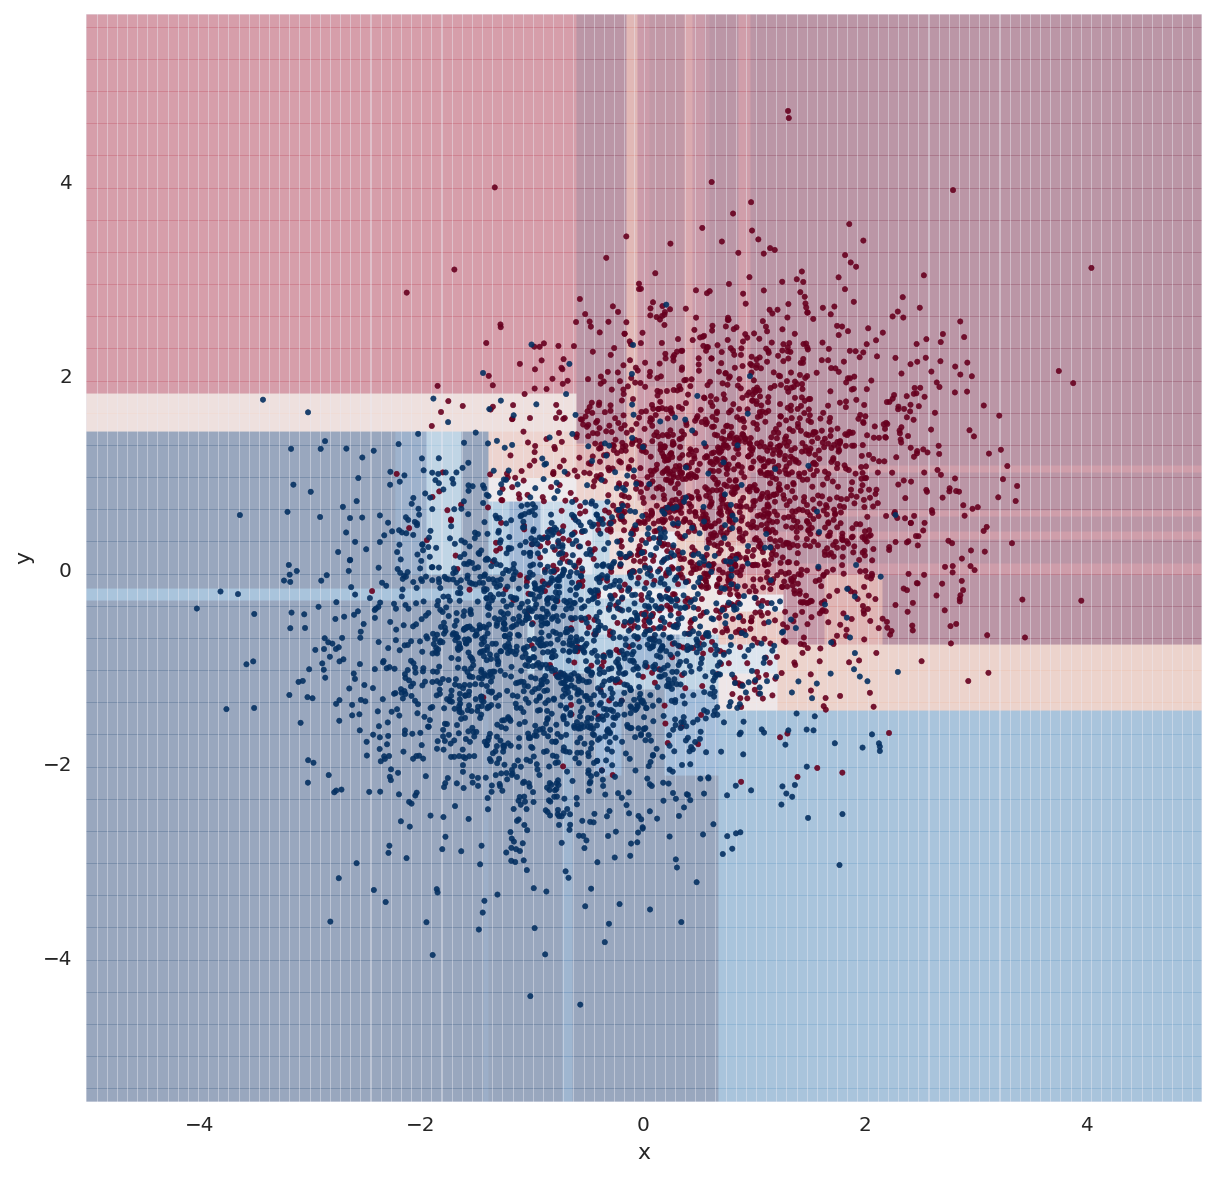

In [14]:
clf = DecisionTreeClassifier(min_samples_leaf=25)
plot_predictions(x, y, clf, proba=True);

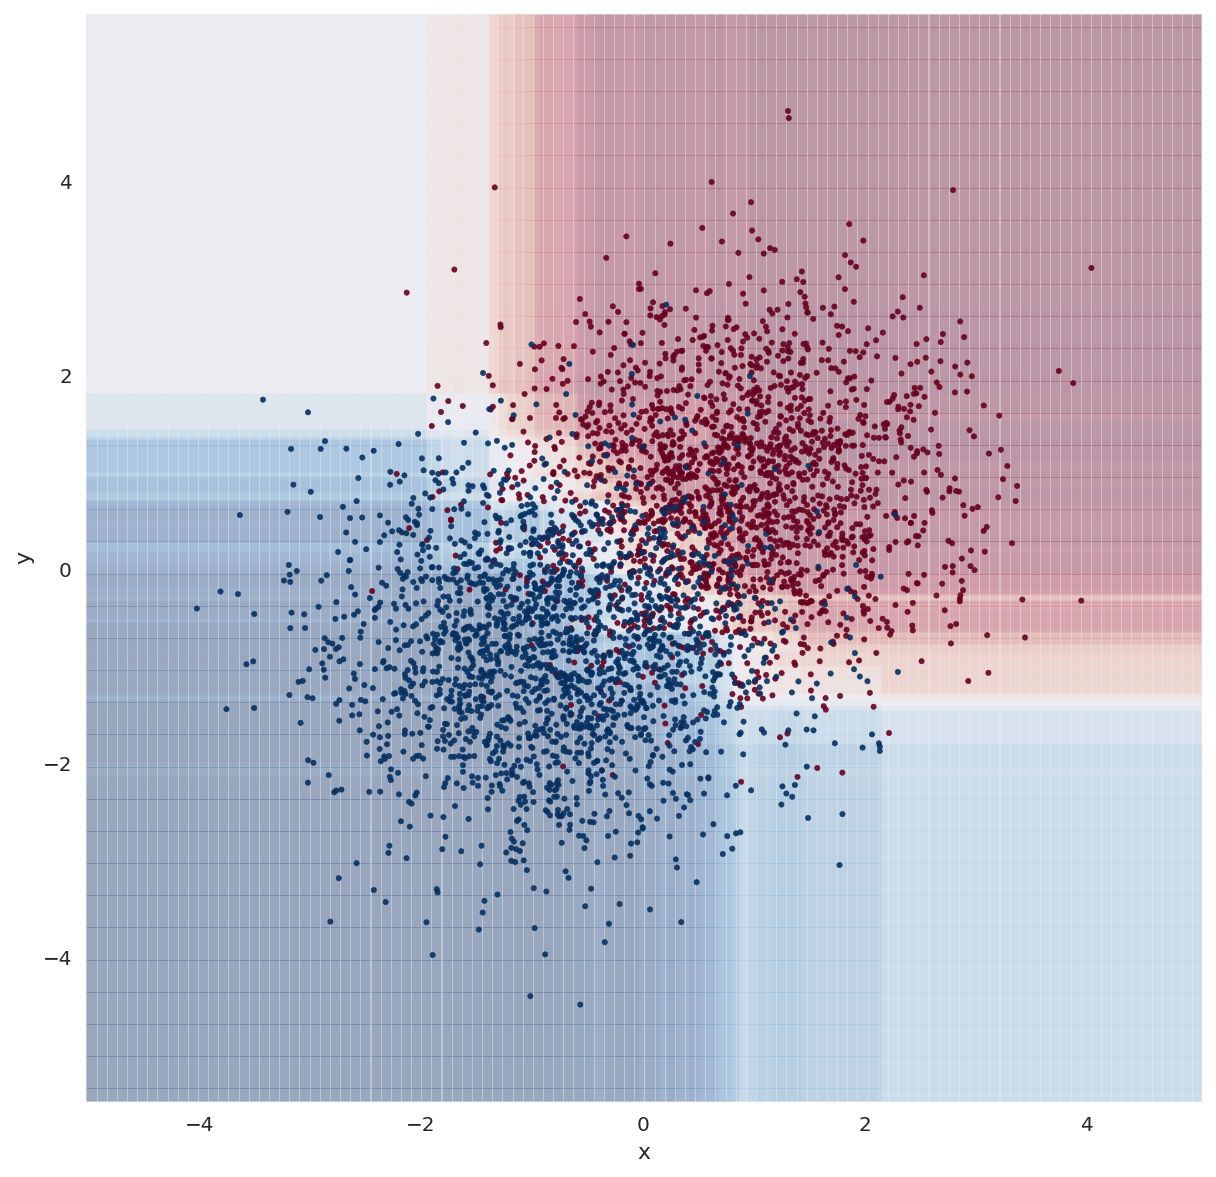

In [13]:
clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=25, n_jobs=-1)
plot_predictions(x, y, clf, proba=True);

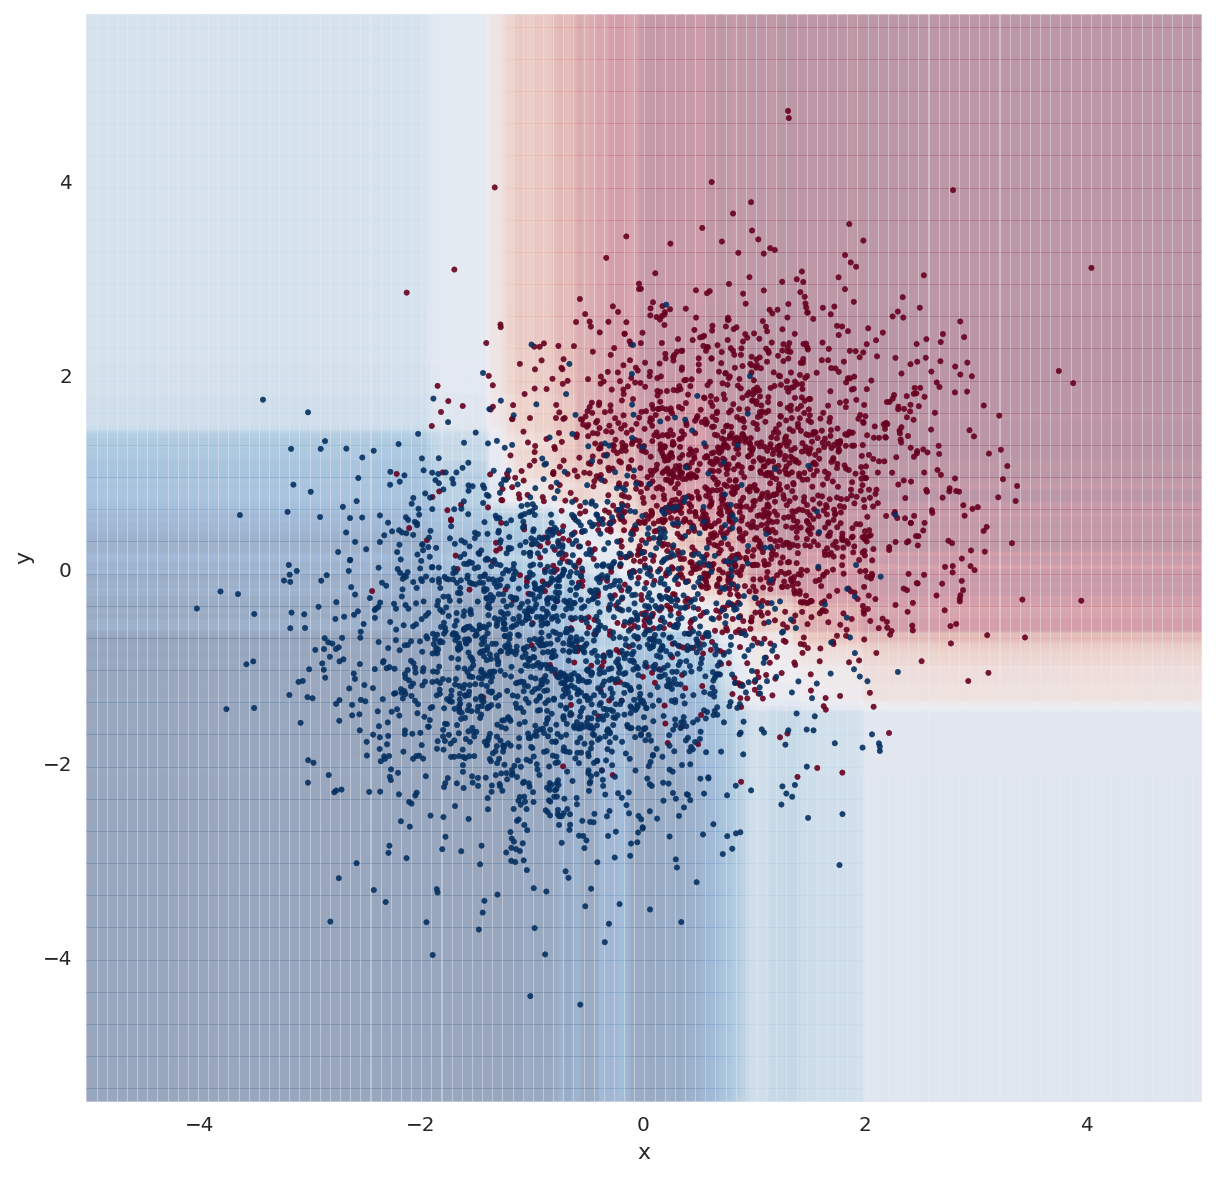

In [10]:
clf = RandomForestClassifier(n_estimators=25, min_samples_leaf=25, n_jobs=-1)
plot_predictions(x, y, clf, proba=True);

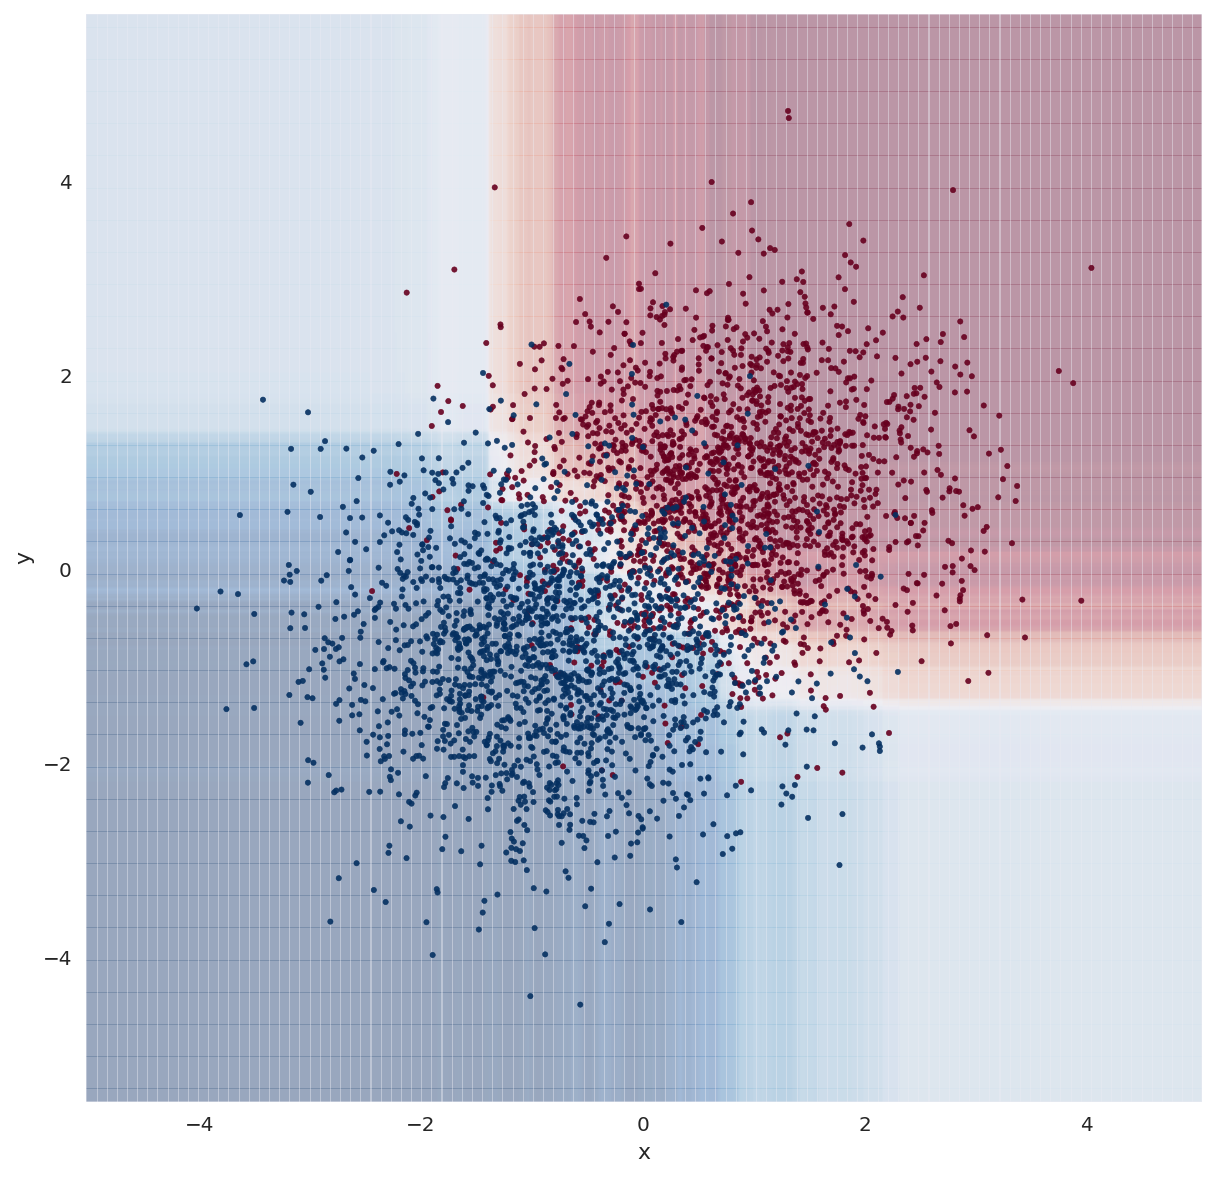

In [11]:
clf = RandomForestClassifier(n_estimators=50, min_samples_leaf=25, n_jobs=-1)
plot_predictions(x, y, clf, proba=True);

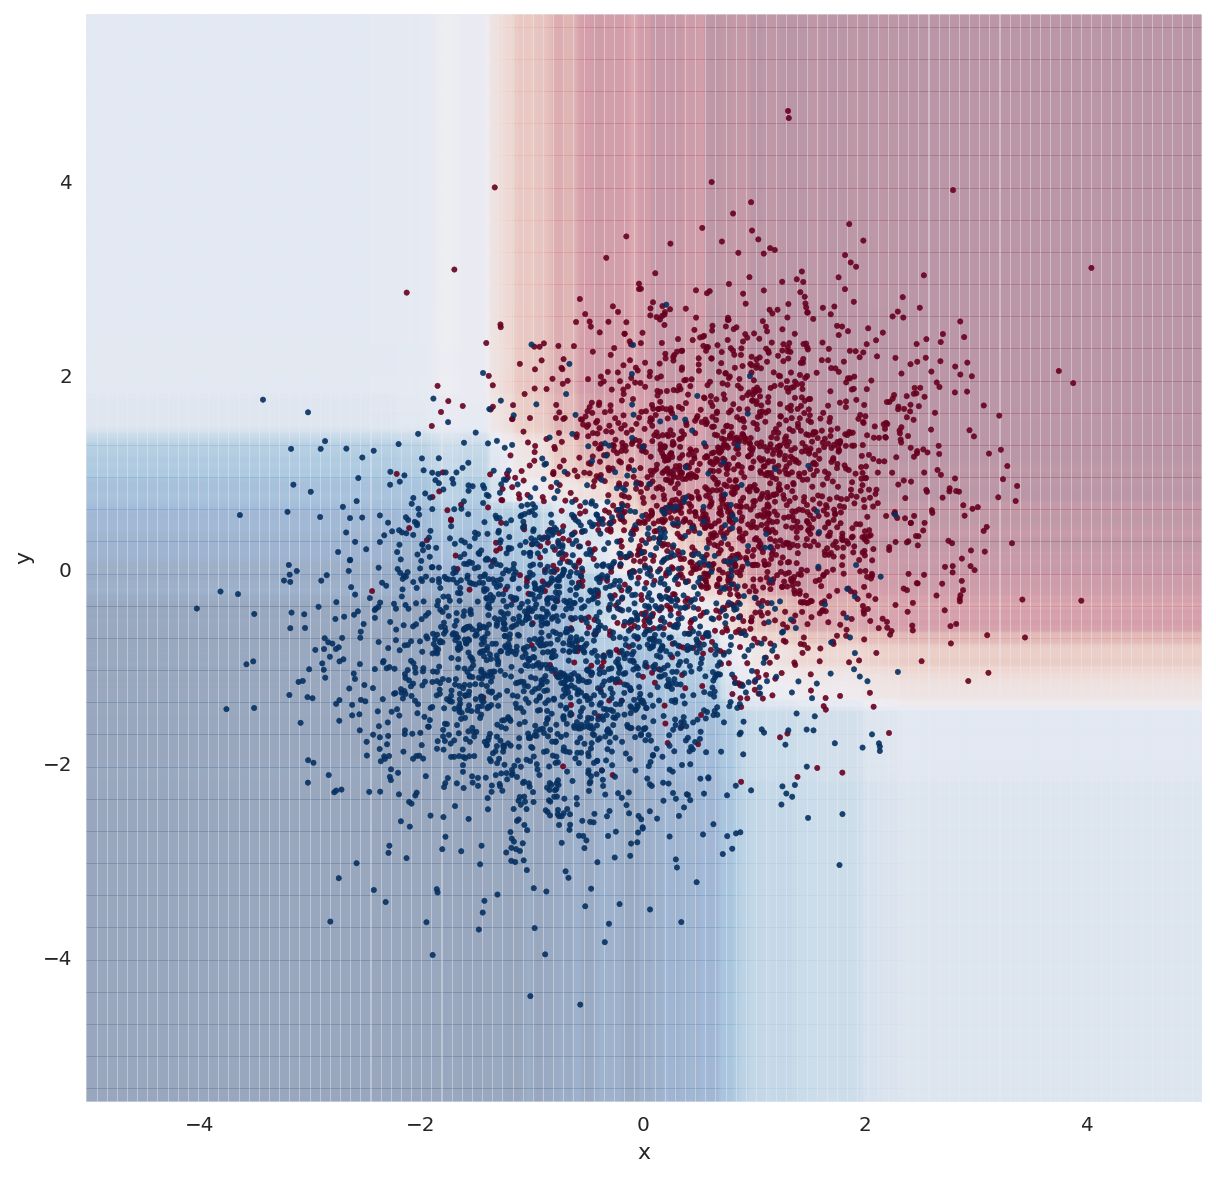

In [12]:
clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=25, n_jobs=-1)
plot_predictions(x, y, clf, proba=True);

## Анализ качества ансамбля
Помимо оценки качества через Out-of-Bag Score случайный лес позволяет оценить "важность" каждого конкретного признака при построении ансамбля.

In [15]:
hr = pd.read_csv('data/HR.csv')
X = hr.drop('left', axis='columns')
y = hr.left

X.head(5)

last_evaluation  number_project  average_montly_hours  time_spend_company  \
0             0.53               2                   157                   3   
1             0.86               5                   262                   6   
2             0.88               7                   272                   4   
3             0.87               5                   223                   5   
4             0.52               2                   159                   3   

   Work_accident  promotion_last_5years  
0              0                      0  
1              0                      0  
2              0                      0  
3              0                      0  
4              0                      0

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42)

In [40]:
clf = RandomForestClassifier(n_estimators=200,
                             max_features=len(X.columns),
                             n_jobs=-1)
clf.fit(X_train, y_train);

In [41]:
clf.feature_importances_

array([0.31351961, 0.15446036, 0.3736135 , 0.12204349, 0.02857649,
       0.00778655])

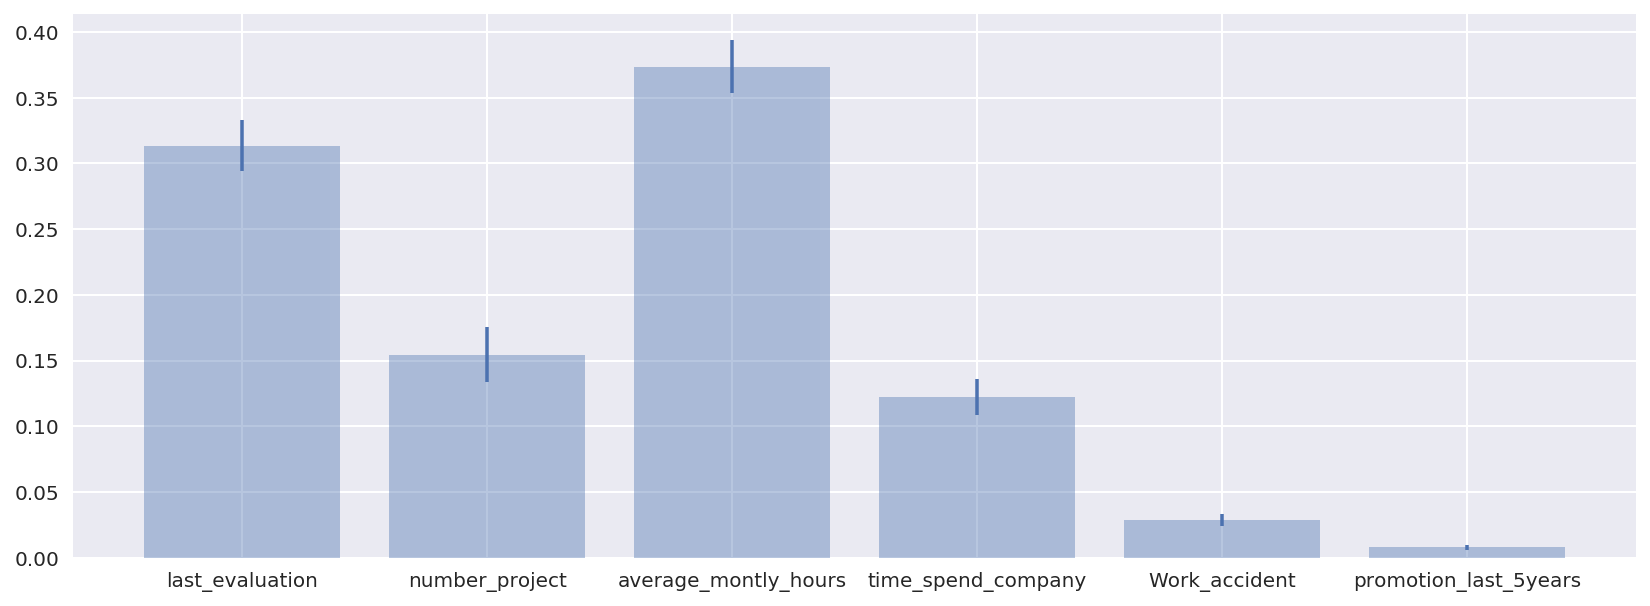

In [42]:
importances_val = clf.feature_importances_
importances_std = np.std([tree.feature_importances_
                          for tree in clf.estimators_], axis=0)

plt.figure(figsize=(14, 5))
plt.bar(X.columns, clf.feature_importances_, yerr=importances_std, alpha=0.4, ecolor='C0');

Можем заметить что важности различаются в зависимости от допустимой свободы в структуре дерева: чем ее меньше, тем больше признаки друг на друга похожи, и тем больше разброс их важности.  

Так что же они обозначают? Автор деревьев в Scikit-Learn описывает [в ответе на Stack Overflow](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined/15821880#15821880) что происходит подсчет так называемых "gini importances". Происходит это так: каждый раз когда происходит разбиение по какому-то признаку во время построения дерева для него подсчитывается следующая характеристика:
$$ I = G_{parent} - G_{split\_left} - G_{split\_right},$$
где $G_{parent}, G_{split\_left}, G_{split\_right}$ $-$ значение критерия Джини для элементов в родительской вершине и в левом и правом потомке соответственно. Подсчет производится по out-of-bag объектам. Затем это значение усредняется по всем выполненным разбиениям.  
Критерий Джини подсчитывается следующим образом:
$$ G = \sum_{i=1}^{n\_classes} p_i (1 - p_i),$$
где $p_i - $ доля класса $i$ в разбиении.  

Такой механизм подсчета важностей не всегда надежен, есть его [критики](http://explained.ai/rf-importance/index.html).

Существуют другие механизмы подсчета важностей, например следующий: для каждой колонки подсчитать исходную точность алгоритма (accuracy или $R^2$ для классификации и регрессии соответственно) и точность после случайной перестановки значений в этой колонке. Точность полученная таким способом надежнее, но труднее в подсчете.  
Такой подсчет важностей реализован в библиотеке `rfpimp`.

In [74]:
clf = RandomForestClassifier(n_estimators=30, max_depth=5, n_jobs=-1, oob_score=True)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

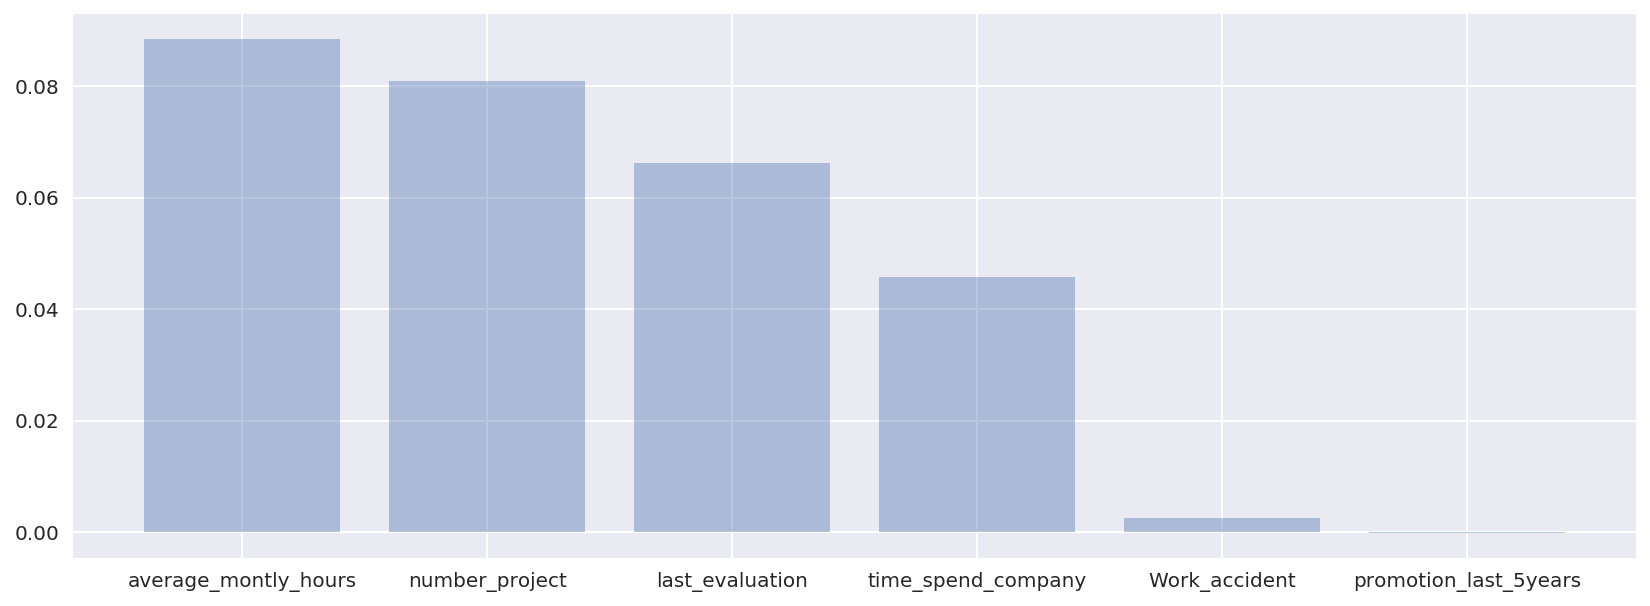

In [75]:
importances = rfpimp.oob_importances(clf, X_train, y_train, n_samples=len(X_train))

plt.figure(figsize=(14, 5))
plt.bar(importances.index, importances.values.reshape(-1), alpha=0.4, ecolor='C0');

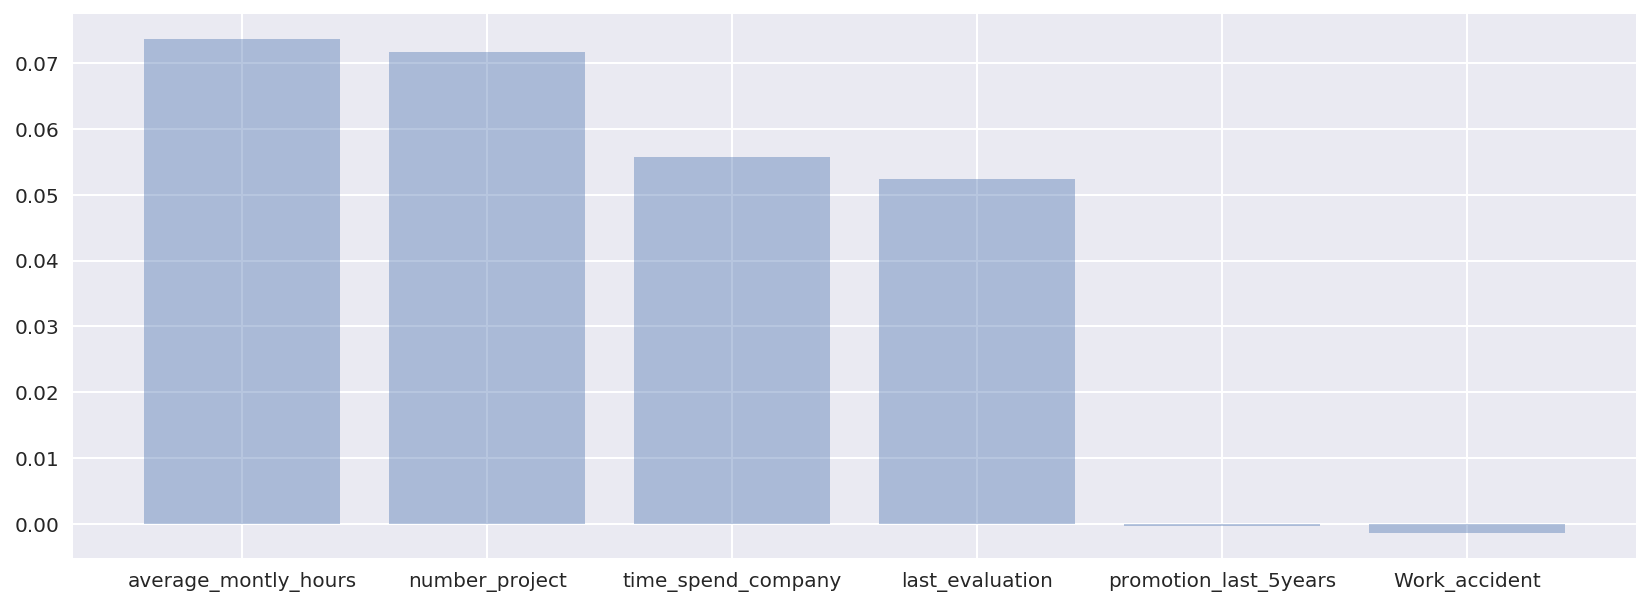

In [44]:
importances = rfpimp.importances(clf, X_valid, y_valid, n_samples=len(X_valid))

plt.figure(figsize=(14, 5))
plt.bar(importances.index, importances.values.reshape(-1), alpha=0.4, ecolor='C0');

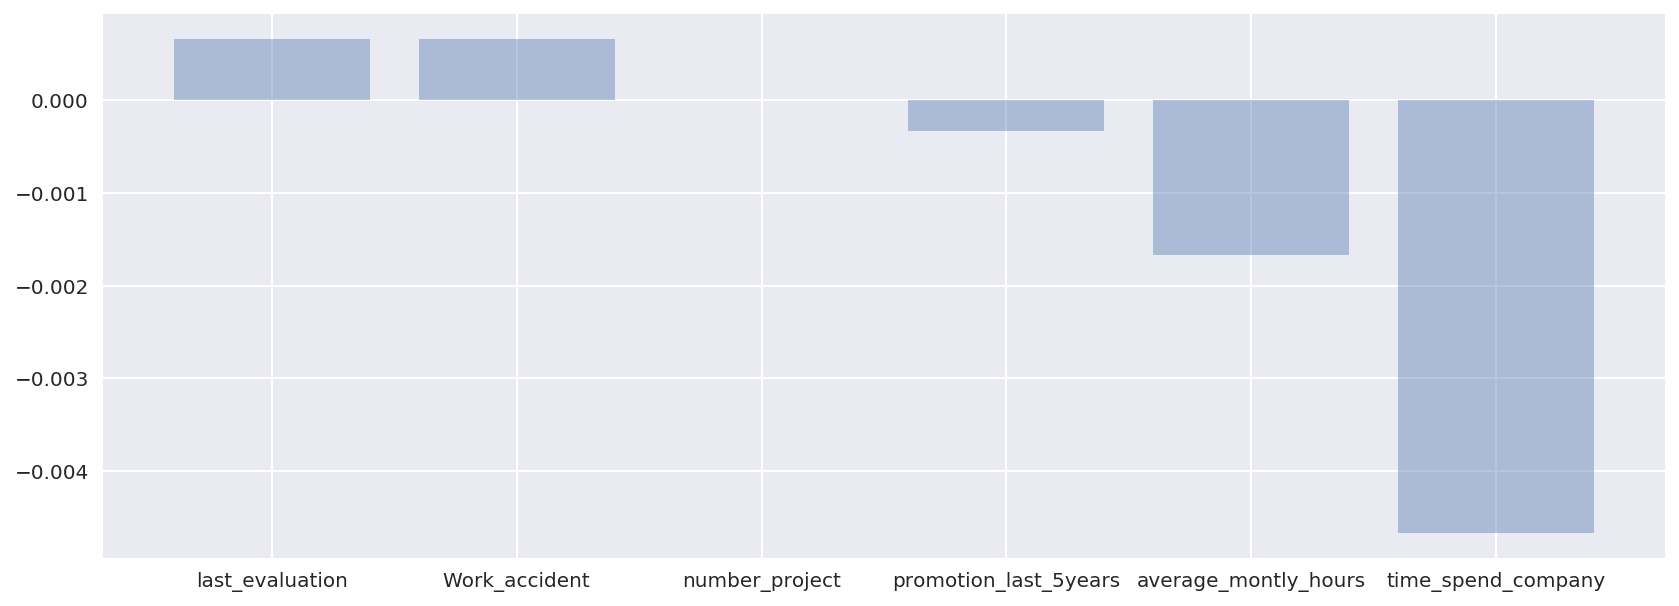

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X)
X_train_scaled, X_valid_scaled, y_train, y_valid = train_test_split(X_scaled, y,
                                                      test_size=0.2,
                                                      random_state=42)

X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X.columns)
clf = LogisticRegression(C=1000000)
clf.fit(X_train_scaled, y_train)
importances = rfpimp.importances(clf,
                                 X_valid_scaled, y_valid,
                                 n_samples=len(X_valid))

plt.figure(figsize=(14, 5))
plt.bar(importances.index, importances.values.reshape(-1), alpha=0.4, ecolor='C0');

In [69]:
np.corrcoef(y_valid, X_valid_scaled.Work_accident)

array([[ 1.        , -0.10186361],
       [-0.10186361,  1.        ]])

Помимо важностей, `rfpimp` позволяет подсчитать зависимости между признаками.

In [78]:
clf = RandomForestClassifier(n_estimators=100, max_depth=7, n_jobs=-1, oob_score=True)
rfpimp.feature_dependence_matrix(clf, X_train[
    ['number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years']
], n_samples=1000)

Dependence number_project average_montly_hours  \
number_project             0.435              1             0.376641   
average_montly_hours       0.021       0.638482                    1   
time_spend_company         0.498       0.167059            0.0814333   
Work_accident              0.853      0.0452177            0.0452184   
promotion_last_5years      0.975      0.0170972           -0.0110787   

                      time_spend_company Work_accident promotion_last_5years  
number_project                  0.323727     0.0210209           -0.00735354  
average_montly_hours            0.255068     0.0983509             0.0190863  
time_spend_company                     1        0.0228             0.0229161  
Work_accident                  0.0331963             1            0.00118281  
promotion_last_5years          0.0667937   -0.00876539                     1

В первой колонке таблице показано то, насколько признак описывается всеми остальными.  
В остальных колонках аналогично, только попарно: в названии колонки указан признак, на котором происходит обучение, а в строке - который предсказывается.

Литература:
* Туториал по важности признаков в случайном лесе: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
* Описание подсчета gini importances: https://stats.stackexchange.com/a/92843
* Репозиторий библиотеки rfpimp: https://github.com/parrt/random-forest-importances
* Критика gini importances: http://explained.ai/rf-importance/index.html